# Asesment of treatment effect on proband P387 Cells
### Famliy 4 - PB000188 - c.1824C>T LMNA
### AreaShape Features only - Normalized on M388 Mother cells with DMSO
### Filtered on <100 >47 cells per well
### https://imagedb.k8s-prod.pharmb.io/?barcode=PB000188&acqid=5538#
### P387 Proband Diseased, M388 Mother Healthy, F389 Father Healthy
### HY-15136 = Lonafarnib, HY-15315 = Baricitinib
#### 2025-11-09 MMJ

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

### Loading data

In [3]:
data = pd.read_csv('/share/data/analyses/martin/036_Progeria_LoBa_48h_72h/004_analysis/PB000188_LoBa_72h_family4_PCA_tSNE_median_M388_norm_AreaShape/data_for_ml/dfZscores Progeria PB000188 LoBa 72h family 4 Zscores normalized on PHB000001_M388 All Features.csv')
data.head(2)

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,...,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,AreaShape_Solidity_nuclei,Count_nuclei
0,PB000188_A02,PB000188,HY-15315,M388_PB000188,HY-15315_0.1,-1.013594,-0.522126,-0.040219,-0.410872,-0.075324,...,-0.106104,-1.304094,-1.661177,-1.966036,-1.004302,-1.207693,1.994335,-0.404440,-0.929323,-0.116691
1,PB000188_A03,PB000188,HY-15136,P387_PB000188,HY-15136_4.0,7.626088,7.455057,1.809851,-0.861000,1.822845,...,5.858948,5.288124,5.610282,6.737703,6.232857,6.359878,1.560321,7.917396,-2.148127,-2.217134


### Dropping count_nuclei (especially since proband wells have less cells in DMSO treatment)

In [4]:
data = data.drop(columns=['Count_nuclei'], errors='ignore')

### All compounds in dataset

In [5]:
list(data.comp_conc.unique())

['HY-15315_0.1',
 'HY-15136_4.0',
 'PHB000001_0.1',
 'PHB000016_10.0',
 'HY-Y0272_10.0',
 'PHB000008_10.0',
 'PHB000018_1.0',
 'PHB000016_3.0',
 'HY-15136_10.0',
 'HY-15136_HY-15315_4.0_1.0',
 'HY-15315_10.0',
 'PHB000006_3.0',
 'HY-15136_HY-15315_4.0_0.4',
 'PHB000006_1.0',
 'PHB000004_10.0',
 'HY-101012_1.0',
 'HY-15315_0.4',
 'PHB000015_3.0',
 'HY-15315_1.0',
 'PHB000010_40.0',
 'SIGMA-428020_10.0',
 'HY-15136_1.0',
 'HY-15315_HY-15136_10.0_1.0',
 'SIGMA-TA9H98772C6C_10.0',
 'HY-15315_HY-15136_4.0_1.0',
 'HY-15136_HY-15315_10.0_10.0',
 'HY-15315_4.0',
 'HY-101012_3.0',
 'SIGMA-TA9H98772C6C_1.0',
 'PHB000012_10.0',
 'SIGMA-428020_1.0',
 'HY-101012_10.0',
 'HY-15315_30.0',
 'HY-15136_0.1',
 'PHB000010_10.0',
 'HY-15136_HY-15315_0.4_1.0',
 'PHB000018_3.0',
 'PHB000010_4.0',
 'HY-15315_HY-15136_4.0_0.4',
 'SIGMA-TA9H98772C6C_3.0',
 'HY-15136_HY-15315_1.0_0.4',
 'HY-15136_0.4',
 'PHB000012_4.0',
 'PHB000006_10.0',
 'PHB000019_1.0',
 'PHB000016_1.0',
 'HY-18258_3.0',
 'HY-Y0272_3.0',
 'HY

### Control compounds

In [6]:
# ["PHB000016", "PHB000018", "PHB000004", "PHB000010", "PHB000008",  "PHB000019", "PHB000012", "PHB000002", "PHB000015", "PHB000006"]

### Baricitinib & Lonafarnib

In [7]:
#["HY-15315", "HY-15136"]

### DMSO

In [8]:
#["PHB000001"]

### Retain DMSO, Lonafarnib and Baricitinib treatments

In [9]:
compounds_to_keep = ['PHB000001', 'HY-15136', 'HY-15315'] # , 'HY-15136', 'HY-15315'
#compounds_to_keep = ["PHB000016", "PHB000018", "PHB000004", "PHB000010", "PHB000008",  "PHB000019", "PHB000012", "PHB000002", "PHB000015"] # 'PHB000001', 'HY-15136', 'HY-15315'
#compounds_to_keep = ["PHB000016", "PHB000018", "PHB000004", "PHB000010", "PHB000008",  "PHB000019", "PHB000012", "PHB000002", "PHB000015", 'PHB000001', 'HY-15136', 'HY-15315']
#data_treatments = data[~data['comp_conc'].str.contains('|'.join(compounds_to_keep))] # EXCLUDE
data_treatments = data[data['comp_conc'].str.contains('|'.join(compounds_to_keep))] # INCLUDE
data_treatments

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,...,AreaShape_MajorAxisLength_nuclei,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,AreaShape_Solidity_nuclei
0,PB000188_A02,PB000188,HY-15315,M388_PB000188,HY-15315_0.1,-1.013594,-0.522126,-0.040219,-0.410872,-0.075324,...,-0.115800,-0.106104,-1.304094,-1.661177,-1.966036,-1.004302,-1.207693,1.994335,-0.404440,-0.929323
1,PB000188_A03,PB000188,HY-15136,P387_PB000188,HY-15136_4.0,7.626088,7.455057,1.809851,-0.861000,1.822845,...,5.271371,5.858948,5.288124,5.610282,6.737703,6.232857,6.359878,1.560321,7.917396,-2.148127
2,PB000188_A04,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,1.393692,1.950029,0.344374,-0.724915,0.288743,...,-0.178672,1.190580,2.709993,0.843610,0.239417,4.554181,3.804085,-1.721005,2.729522,-9.638532
8,PB000188_A11,PB000188,HY-15136,F389_PB000188,HY-15136_10.0,5.378685,6.746782,-0.810662,-0.465830,-0.878782,...,4.799369,5.540457,2.636857,2.778792,2.785621,5.278017,3.712580,0.401285,7.458812,-12.822840
9,PB000188_A12,PB000188,HY-15136_HY-15315,P387_PB000188,HY-15136_HY-15315_4.0_1.0,1.882389,2.923908,2.297505,-2.159042,2.094012,...,-0.758622,-0.136528,2.868288,1.740729,0.478834,3.767895,3.509291,0.225210,3.131420,-6.317516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,PB000188_P05,PB000188,HY-15136,F389_PB000188,HY-15136_4.0,-2.763250,-2.043103,0.653557,0.222447,0.557399,...,-2.830935,-2.739420,-2.252277,-3.095056,-4.286256,-1.661837,-2.427952,0.662946,-2.113139,-10.461355
232,PB000188_P08,PB000188,HY-15315,M388_PB000188,HY-15315_30.0,0.036200,0.499425,2.201985,0.217213,2.164315,...,-0.077047,-2.040207,-1.156431,-1.915748,-4.021571,2.112465,2.300174,-1.108036,2.906463,-14.275661
234,PB000188_P12,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,4.175042,5.221264,0.437381,0.395170,0.349002,...,0.693928,2.516584,5.225880,3.707407,4.148897,6.902572,6.592543,0.033452,5.010929,-6.538273
236,PB000188_P16,PB000188,HY-15315,P387_PB000188,HY-15315_0.1,2.425386,2.183851,-1.119845,-1.019330,-1.182590,...,0.710845,0.906551,2.996404,2.425751,1.183065,4.043522,4.070372,1.032328,2.729524,-5.073268


### Checking number of wells per person

In [10]:
counts = data['person_plate'].str[:4].value_counts().loc[['P387', 'M388', 'F389']]
counts

person_plate
P387    144
M388     50
F389     45
Name: count, dtype: int64

### Select what subjects to keep for training the model

In [11]:
persons_to_keep = ['P387', 'M388'] # 'M388' 'F389'
data_treatments_ready = data_treatments[data_treatments['person_plate'].str.contains('|'.join(persons_to_keep))]
data_treatments_ready

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,...,AreaShape_MajorAxisLength_nuclei,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,AreaShape_Solidity_nuclei
0,PB000188_A02,PB000188,HY-15315,M388_PB000188,HY-15315_0.1,-1.013594,-0.522126,-0.040219,-0.410872,-0.075324,...,-0.115800,-0.106104,-1.304094,-1.661177,-1.966036,-1.004302,-1.207693,1.994335,-0.404440,-0.929323
1,PB000188_A03,PB000188,HY-15136,P387_PB000188,HY-15136_4.0,7.626088,7.455057,1.809851,-0.861000,1.822845,...,5.271371,5.858948,5.288124,5.610282,6.737703,6.232857,6.359878,1.560321,7.917396,-2.148127
2,PB000188_A04,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,1.393692,1.950029,0.344374,-0.724915,0.288743,...,-0.178672,1.190580,2.709993,0.843610,0.239417,4.554181,3.804085,-1.721005,2.729522,-9.638532
9,PB000188_A12,PB000188,HY-15136_HY-15315,P387_PB000188,HY-15136_HY-15315_4.0_1.0,1.882389,2.923908,2.297505,-2.159042,2.094012,...,-0.758622,-0.136528,2.868288,1.740729,0.478834,3.767895,3.509291,0.225210,3.131420,-6.317516
10,PB000188_A13,PB000188,HY-15315,P387_PB000188,HY-15315_10.0,7.203757,8.090690,0.490168,0.431808,0.522248,...,3.685573,4.298322,6.960707,5.283629,6.098461,9.214566,8.452050,-0.113914,8.197246,-5.873598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,PB000188_P02,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,0.808462,1.257644,0.128198,-0.065426,0.026363,...,2.063468,1.897655,0.394887,0.227082,0.119708,0.316039,0.279082,-0.605774,1.386973,0.118031
232,PB000188_P08,PB000188,HY-15315,M388_PB000188,HY-15315_30.0,0.036200,0.499425,2.201985,0.217213,2.164315,...,-0.077047,-2.040207,-1.156431,-1.915748,-4.021571,2.112465,2.300174,-1.108036,2.906463,-14.275661
234,PB000188_P12,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,4.175042,5.221264,0.437381,0.395170,0.349002,...,0.693928,2.516584,5.225880,3.707407,4.148897,6.902572,6.592543,0.033452,5.010929,-6.538273
236,PB000188_P16,PB000188,HY-15315,P387_PB000188,HY-15315_0.1,2.425386,2.183851,-1.119845,-1.019330,-1.182590,...,0.710845,0.906551,2.996404,2.425751,1.183065,4.043522,4.070372,1.032328,2.729524,-5.073268


### Checking treatment replicates combined in P387 & M388

In [12]:
#counts_trt = data_treatments_ready['comp_conc'].value_counts()
#counts_trt

### Replicates in treatments per person

In [13]:
replicate_counts = (
    data_treatments_ready
    .assign(person_prefix=data_treatments_ready['person_plate'].str[:4])
    .groupby(['person_prefix', 'comp_conc'])
    .size()
    .reset_index(name='replicates'))
replicate_counts

,person_prefix,comp_conc,replicates
0,M388,HY-15136_0.1,2
1,M388,HY-15136_0.4,2
2,M388,HY-15136_1.0,2
3,M388,HY-15136_10.0,2
4,M388,HY-15136_4.0,2
5,M388,HY-15315_0.1,2
6,M388,HY-15315_0.4,2
7,M388,HY-15315_1.0,2
8,M388,HY-15315_10.0,2
9,M388,HY-15315_30.0,1


# # Setting up data for modeling P387 in DMSO and M388 in DMSO only 

In [14]:
data_P387_M388_dmso = data_treatments_ready[data_treatments_ready['comp_conc'] == 'PHB000001_0.1']
data_P387_M388_dmso = data_P387_M388_dmso.sort_values(by='person_plate')
print("Unique compounds in data: ",data_P387_M388_dmso.comp_conc.unique()) # DMSO = 'PHB000001_0.1'
data_P387_M388_dmso.head()

Unique compounds in data:  ['PHB000001_0.1']


,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,...,AreaShape_MajorAxisLength_nuclei,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,AreaShape_Solidity_nuclei
238,PB000188_P20,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-0.147816,0.733247,0.118143,0.172723,0.106709,...,0.733681,1.115890,-0.453477,-0.469454,0.000000,-0.329258,-0.451273,0.270108,0.806862,-0.329829
144,PB000188_J08,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-1.242859,-0.912586,0.020109,-0.539106,-0.027619,...,-0.356520,-0.840055,-0.504866,-0.827303,-1.474526,-0.878453,-0.911149,0.151862,-0.817254,-0.260748
139,PB000188_J02,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,0.253399,-0.227011,1.342306,0.829596,1.270468,...,-0.737941,-0.866909,1.801927,1.108737,0.478834,1.901311,0.996306,-0.162635,0.142989,-0.402768
135,PB000188_I20,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,0.000000,0.839943,-0.125684,-0.929042,-0.128051,...,0.643842,0.000000,0.330179,0.183196,0.000000,0.434474,0.507145,1.189371,0.479525,1.347227
174,PB000188_L08,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,0.929128,1.107816,-1.589904,-1.096532,-1.569254,...,-0.121291,0.312813,1.435277,0.728300,0.593235,1.412404,1.143197,-0.962979,1.001679,-0.037418


### Encoding dummies

In [15]:
#data_P387_M388_dmso_encoded = pd.get_dummies(
#    data_P387_M388_dmso,
#    columns=['person_plate'],
#    prefix='person_plate')
#data_P387_M388_dmso_encoded.head()

### This data is now ready for training models

In [16]:
data_P387_M388_dmso.head(2)

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,...,AreaShape_MajorAxisLength_nuclei,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,AreaShape_Solidity_nuclei
238,PB000188_P20,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-0.147816,0.733247,0.118143,0.172723,0.106709,...,0.733681,1.115890,-0.453477,-0.469454,0.000000,-0.329258,-0.451273,0.270108,0.806862,-0.329829
144,PB000188_J08,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-1.242859,-0.912586,0.020109,-0.539106,-0.027619,...,-0.356520,-0.840055,-0.504866,-0.827303,-1.474526,-0.878453,-0.911149,0.151862,-0.817254,-0.260748


# Logistic Regression

### Define target column based on person_plate groups

In [17]:
df = data_P387_M388_dmso.copy()
df['target'] = df['person_plate'].str.startswith('P387').astype(int) # M388 = 0, P387 = 1
df.head(2)

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,...,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,AreaShape_Solidity_nuclei,target
238,PB000188_P20,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-0.147816,0.733247,0.118143,0.172723,0.106709,...,1.115890,-0.453477,-0.469454,0.000000,-0.329258,-0.451273,0.270108,0.806862,-0.329829,0
144,PB000188_J08,PB000188,PHB000001,M388_PB000188,PHB000001_0.1,-1.242859,-0.912586,0.020109,-0.539106,-0.027619,...,-0.840055,-0.504866,-0.827303,-1.474526,-0.878453,-0.911149,0.151862,-0.817254,-0.260748,0


### Drop non-feature columns and setting up X and y

In [18]:
non_feature_cols = [c for c in df.columns if c.startswith('person_plate') or c == 'comp_conc' or c == 'plate' or c == 'batch_id' or c == 'WellID' or c == 'target']
X = df.drop(columns=non_feature_cols)
y = df['target']

### Split data into train and test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### Training the mode (LASSO or LogisticRegression)

In [20]:
# --- Logistic LASSO (L1-penalized logistic regression) ---
#log_lasso = LogisticRegressionCV(
#    penalty='l1',
#    solver='saga',  # supports L1 penalty
#    cv=5,
#    scoring='roc_auc',
#    max_iter=5000,
#    n_jobs=-1,
#    refit=True)

log_none = LogisticRegression(penalty=None, solver='lbfgs', max_iter=5000)
# penalty no regularization -> no coefficients forced to zero
# solver lbfgs supports penalty='none'

#log_lasso.fit(X_train, y_train)
log_none.fit(X_train, y_train)

LogisticRegression(max_iter=5000, penalty=None)

In [21]:
# --- Evaluate on test set ---
y_pred = log_none.predict(X_test)
y_pred_proba = log_none.predict_proba(X_test)[:, 1] # USE log_lasso

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

Confusion Matrix:
 [[7 0]
 [0 7]]
ROC-AUC: 1.0000


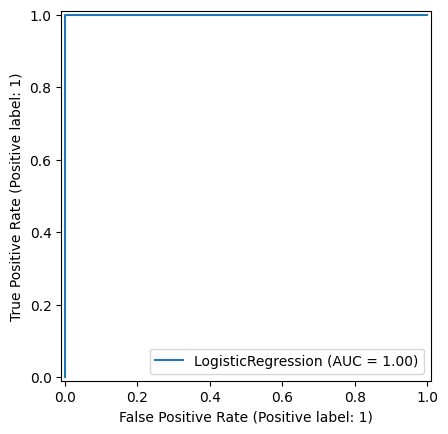

In [22]:
# --- Plot ROC curve ---
RocCurveDisplay.from_estimator(log_none, X_test, y_test)
plt.show()

### Inspecting coefficients (feature contribution to decision)

In [23]:
coefs = pd.Series(log_none.coef_.ravel(), index=X.columns)
nonzero = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)

print("\nNon-zero Logistic LASSO coefficients (sorted by |coef|):")
print(nonzero)


Non-zero Logistic LASSO coefficients (sorted by |coef|):
AreaShape_Eccentricity_nuclei           -2.243959
AreaShape_MedianRadius_nuclei            2.239602
AreaShape_Solidity_nuclei               -1.415234
AreaShape_MaximumRadius_nuclei          -1.066114
AreaShape_FormFactor_nuclei             -0.980287
AreaShape_Perimeter_nuclei               0.914714
AreaShape_Compactness_nuclei             0.869074
AreaShape_BoundingBoxArea_nuclei        -0.455078
AreaShape_BoundingBoxMaximum_X_nuclei   -0.344452
AreaShape_Orientation_nuclei             0.219605
AreaShape_BoundingBoxMinimum_Y_nuclei   -0.184761
AreaShape_MajorAxisLength_nuclei        -0.172854
AreaShape_MeanRadius_nuclei             -0.166396
AreaShape_BoundingBoxMinimum_X_nuclei    0.152851
AreaShape_BoundingBoxMaximum_Y_nuclei    0.152372
AreaShape_MinorAxisLength_nuclei        -0.126562
AreaShape_EquivalentDiameter_nuclei      0.119523
AreaShape_Extent_nuclei                  0.100820
AreaShape_Center_Y_nuclei                0

### Store results in a DataFrame

In [24]:
coef_df = (
    pd.DataFrame({'feature': X.columns, 'coef': log_none.coef_.ravel()})
      .assign(abs_coef=lambda d: d['coef'].abs())
      .sort_values('abs_coef', ascending=False)
      .reset_index(drop=True))

print("\nTop 20 features by |coef|:")
print(coef_df.head(20))


Top 20 features by |coef|:
                                  feature      coef  abs_coef
0           AreaShape_Eccentricity_nuclei -2.243959  2.243959
1           AreaShape_MedianRadius_nuclei  2.239602  2.239602
2               AreaShape_Solidity_nuclei -1.415234  1.415234
3          AreaShape_MaximumRadius_nuclei -1.066114  1.066114
4             AreaShape_FormFactor_nuclei -0.980287  0.980287
5              AreaShape_Perimeter_nuclei  0.914714  0.914714
6            AreaShape_Compactness_nuclei  0.869074  0.869074
7        AreaShape_BoundingBoxArea_nuclei -0.455078  0.455078
8   AreaShape_BoundingBoxMaximum_X_nuclei -0.344452  0.344452
9            AreaShape_Orientation_nuclei  0.219605  0.219605
10  AreaShape_BoundingBoxMinimum_Y_nuclei -0.184761  0.184761
11       AreaShape_MajorAxisLength_nuclei -0.172854  0.172854
12            AreaShape_MeanRadius_nuclei -0.166396  0.166396
13  AreaShape_BoundingBoxMinimum_X_nuclei  0.152851  0.152851
14  AreaShape_BoundingBoxMaximum_Y_nuclei 

### Plotting the data

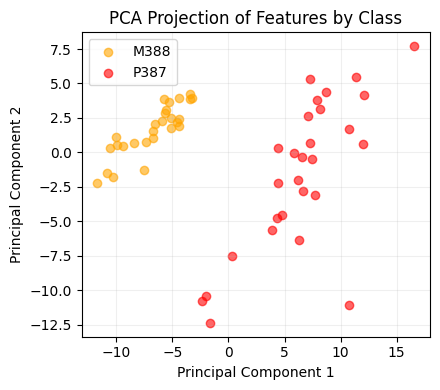

In [26]:
# Perform PCA to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot of the two principal components, color-coded by class
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['target'] = y.values

# Adding the target and person_plate columns for plotting
if len(df_plot) != len(df):
    raise ValueError("Lengths differ; cannot merge row-wise.")

# Adding the information
df_plot['person_plate'] = df['person_plate'].to_numpy()
df_plot['target']       = df['target'].to_numpy()
df_plot['person_plate'] = df_plot['person_plate'].astype(str).str[:4] # Retaining only first 4 character for P287 and M388

plt.figure(figsize=(4.5,4))
colors = {0: 'orange', 1: 'red'}
for label in df_plot['target'].unique():
    subset = df_plot[df_plot['target'] == label]
    legend_label = subset['person_plate'].mode()[0]
    plt.scatter(subset['PC1'], subset['PC2'],
                label=legend_label,
                alpha=0.6, color=colors[label])

plt.title('PCA Projection of Features by Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### PCA on data prior to Logistic Regression

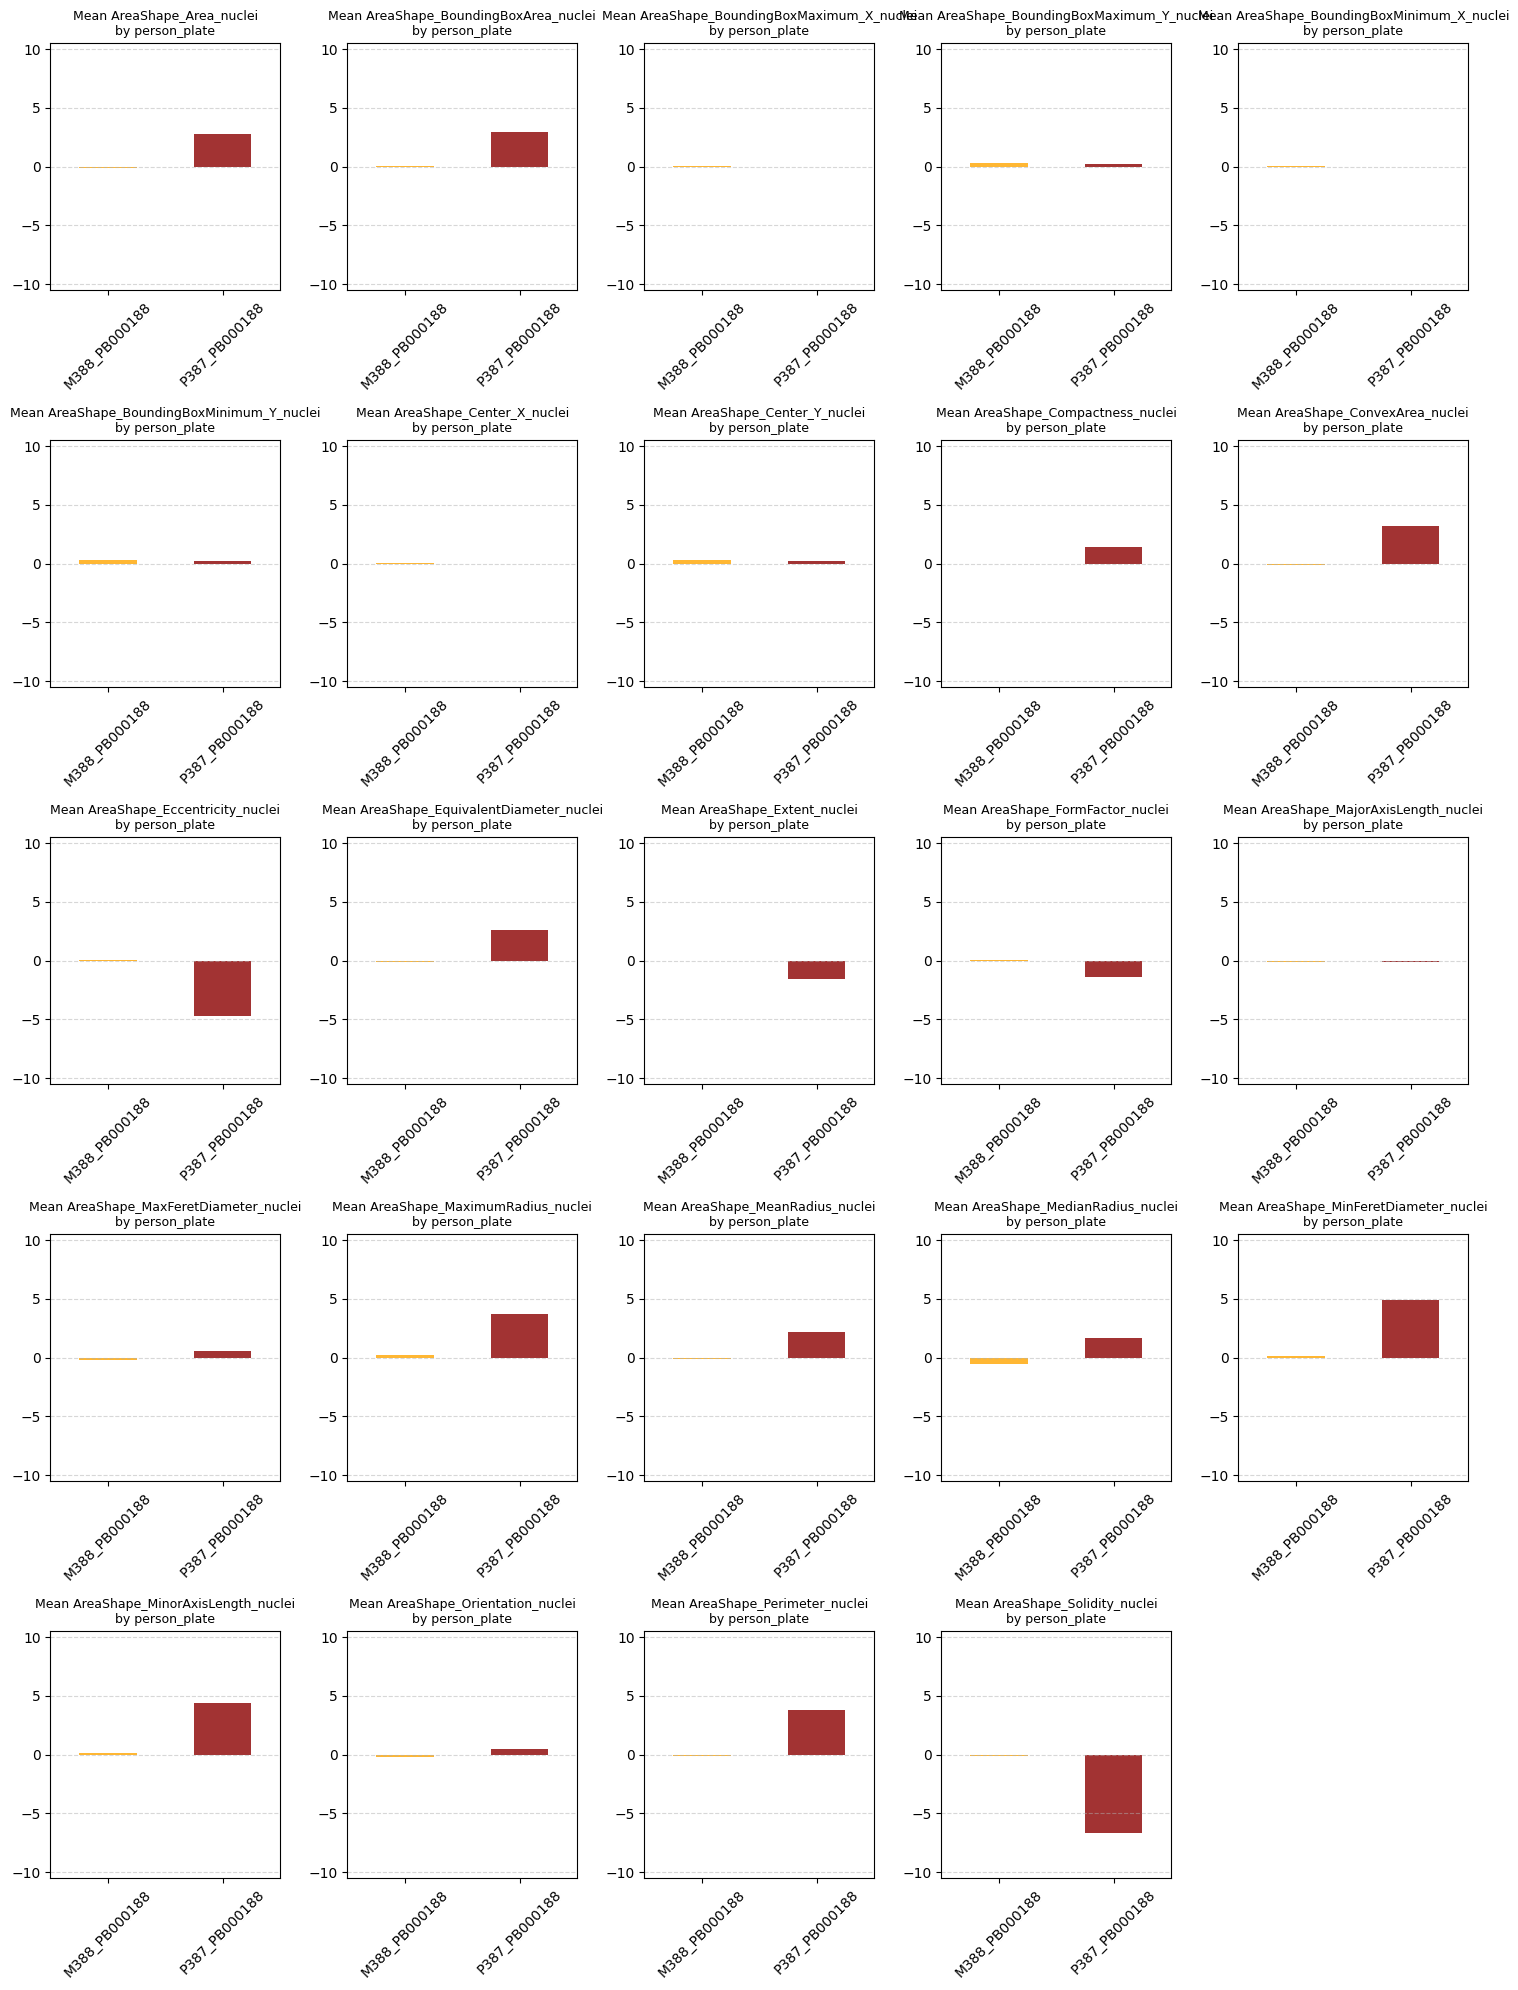

In [27]:
# --- Parameters to adjust ---
plot_width, plot_height = 3, 4  # size of individual subplots
num_cols = data_P387_M388_dmso.columns[5:30]
means = data_P387_M388_dmso.groupby('person_plate')[num_cols].mean(numeric_only=True)
max_y = 10

# Determine grid size for as-square-as-possible layout
n_plots = len(num_cols)
n_cols = int(math.ceil(math.sqrt(n_plots)))
n_rows = int(math.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * plot_width, n_rows * plot_height))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    means[col].plot(kind='bar', color=['orange', 'darkred'], alpha=0.8, ax=ax)
    ax.set_title(f'Mean {col}\nby person_plate', fontsize=9)
    ax.set_xlabel('')
    ax.set_ylim(-10 * 1.05, max_y * 1.05)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=45)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# -----------------------------
# Preparing data for prediction

In [28]:
persons_to_keep = ['P387', 'M388', 'F389'] #, 'F389']
treated = data[data['person_plate'].str.contains('|'.join(persons_to_keep))]
treated.head(3)

,WellID,plate,batch_id,person_plate,comp_conc,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,...,AreaShape_MajorAxisLength_nuclei,AreaShape_MaxFeretDiameter_nuclei,AreaShape_MaximumRadius_nuclei,AreaShape_MeanRadius_nuclei,AreaShape_MedianRadius_nuclei,AreaShape_MinFeretDiameter_nuclei,AreaShape_MinorAxisLength_nuclei,AreaShape_Orientation_nuclei,AreaShape_Perimeter_nuclei,AreaShape_Solidity_nuclei
0,PB000188_A02,PB000188,HY-15315,M388_PB000188,HY-15315_0.1,-1.013594,-0.522126,-0.040219,-0.410872,-0.075324,...,-0.115800,-0.106104,-1.304094,-1.661177,-1.966036,-1.004302,-1.207693,1.994335,-0.404440,-0.929323
1,PB000188_A03,PB000188,HY-15136,P387_PB000188,HY-15136_4.0,7.626088,7.455057,1.809851,-0.861000,1.822845,...,5.271371,5.858948,5.288124,5.610282,6.737703,6.232857,6.359878,1.560321,7.917396,-2.148127
2,PB000188_A04,PB000188,PHB000001,P387_PB000188,PHB000001_0.1,1.393692,1.950029,0.344374,-0.724915,0.288743,...,-0.178672,1.190580,2.709993,0.843610,0.239417,4.554181,3.804085,-1.721005,2.729522,-9.638532


In [29]:
treated.comp_conc.unique()

array(['HY-15315_0.1', 'HY-15136_4.0', 'PHB000001_0.1', 'PHB000016_10.0',
       'HY-Y0272_10.0', 'PHB000008_10.0', 'PHB000018_1.0',
       'PHB000016_3.0', 'HY-15136_10.0', 'HY-15136_HY-15315_4.0_1.0',
       'HY-15315_10.0', 'PHB000006_3.0', 'HY-15136_HY-15315_4.0_0.4',
       'PHB000006_1.0', 'PHB000004_10.0', 'HY-101012_1.0', 'HY-15315_0.4',
       'PHB000015_3.0', 'HY-15315_1.0', 'PHB000010_40.0',
       'SIGMA-428020_10.0', 'HY-15136_1.0', 'HY-15315_HY-15136_10.0_1.0',
       'SIGMA-TA9H98772C6C_10.0', 'HY-15315_HY-15136_4.0_1.0',
       'HY-15136_HY-15315_10.0_10.0', 'HY-15315_4.0', 'HY-101012_3.0',
       'SIGMA-TA9H98772C6C_1.0', 'PHB000012_10.0', 'SIGMA-428020_1.0',
       'HY-101012_10.0', 'HY-15315_30.0', 'HY-15136_0.1',
       'PHB000010_10.0', 'HY-15136_HY-15315_0.4_1.0', 'PHB000018_3.0',
       'PHB000010_4.0', 'HY-15315_HY-15136_4.0_0.4',
       'SIGMA-TA9H98772C6C_3.0', 'HY-15136_HY-15315_1.0_0.4',
       'HY-15136_0.4', 'PHB000012_4.0', 'PHB000006_10.0', 'PHB000019_1.

### Dropping the DMSO data

In [33]:
#treated_ready = treated[~treated['comp_conc'].astype(str).str.contains('PHB000001_0.1', na=False)].copy()
#treated_ready

### Dropping classical controls

In [30]:
#compounds_to_keep = ["PHB000016", "PHB000018", "PHB000004", "PHB000010", "PHB000008",  "PHB000019", "PHB000012", "PHB000002", "PHB000015", 'PHB000001', 'HY-15136', 'HY-15315']
#treated_ready = data[~data['comp_conc'].str.contains('|'.join(compounds_to_keep))] # EXCLUDE
treated_ready = treated

### Subsetting F389 data

In [35]:
#persons_to_keep2 = ['M388'] 
#treated2 = data_treatments[data_treatments['person_plate'].str.contains('|'.join(persons_to_keep2))]
#treated2.head(3)

### Retaining only DMSO data

In [34]:
##treated_ready2 = treated2[treated2['comp_conc'].astype(str).str.contains('PHB000001_0.1', na=False)].copy() # Retain DMSO
#treated_ready2 = treated2[~treated2['comp_conc'].astype(str).str.contains('PHB000001_0.1', na=False)].copy() # Non DMSO
#print("treated_ready2: ", treated_ready2.shape)
#treated_ready2.head(3)

### Appending P387 and M388 data

In [30]:
#treated_ready = pd.concat([treated_ready, treated_ready2], ignore_index=True)

### Wells per subject

In [31]:
class_counts = treated_ready['person_plate'].value_counts()
print(class_counts)

person_plate
P387_PB000188    144
M388_PB000188     50
F389_PB000188     45
Name: count, dtype: int64


### Classifying data

In [32]:
# features used during training
feats = feature_cols if 'feature_cols' in locals() else list(X.columns)

# align features
for c in feats:
    if c not in treated_ready.columns:
        treated_ready[c] = 0.0
X_t = treated_ready[feats].apply(pd.to_numeric, errors='coerce').fillna(0.0)

# predict
proba = log_none.predict_proba(X_t)[:, 1]
pred = (proba >= 0.5).astype(int)

# results
results = treated_ready.copy()
results['pred_class'] = np.where(pred == 1, 'P387', 'M388')
results['proba_P387'] = proba
results['proba_P387'] = np.round(proba, 2)  # shorten decimals to 2

print('Total samples:', len(results))
print('\nPredicted class counts:')
print(results['pred_class'].value_counts(dropna=False))
print('\nPreview:')
print(results[['pred_class','proba_P387']].head())

# optional evaluation if labels exist
if 'person_plate' in treated_ready.columns:
    y_true = treated_ready['person_plate'].astype(str).str.startswith('P387').astype(int)
    all_labels = [0, 1]  # 0=M388, 1=P387

    # Always pass labels so shapes are consistent even if only one class is present
    print('Confusion Matrix:', confusion_matrix(y_true, pred, labels=all_labels))

    # Classification report with explicit labels and safe handling for zero divisions
    print('Classification Report:', classification_report(
        y_true, pred,
        labels=all_labels,
        target_names=['M388','P387'],
        zero_division=0
    ))

    # Helpful notes if only one class is present
    if np.unique(y_true).size < 2:
        print('Note: Only one class present in ground truth (y_true); some metrics are not informative.')
    if np.unique(pred).size < 2:
        print('Note: Model predicted only one class for all samples; precision/recall for the other class will be zero.')

    # ROC-AUC is undefined if y_true has a single class
    if np.unique(y_true).size == 2:
        try:
            print('ROC-AUC:', f"{roc_auc_score(y_true, proba):.4f}")
        except Exception as e:
            print('ROC-AUC not computed:', e)
    else:
        print('ROC-AUC: skipped (only one class present in y_true).')
else:
    print('No ground-truth labels found in `treated`; skipped evaluation metrics.')


Total samples: 239

Predicted class counts:
pred_class
P387    170
M388     69
Name: count, dtype: int64

Preview:
  pred_class  proba_P387
0       M388         0.0
1       P387         1.0
2       P387         1.0
3       P387         1.0
4       P387         1.0
Confusion Matrix: [[ 66  29]
 [  3 141]]
Classification Report:               precision    recall  f1-score   support

        M388       0.96      0.69      0.80        95
        P387       0.83      0.98      0.90       144

    accuracy                           0.87       239
   macro avg       0.89      0.84      0.85       239
weighted avg       0.88      0.87      0.86       239

ROC-AUC: 0.9010


In [33]:
# ==== FULL list of probabilities 
#print('\nPredictions (all rows):')
#print(results[['pred_class','proba_P387']].to_string(index=True))

### Visualizing classification with compound name and conc

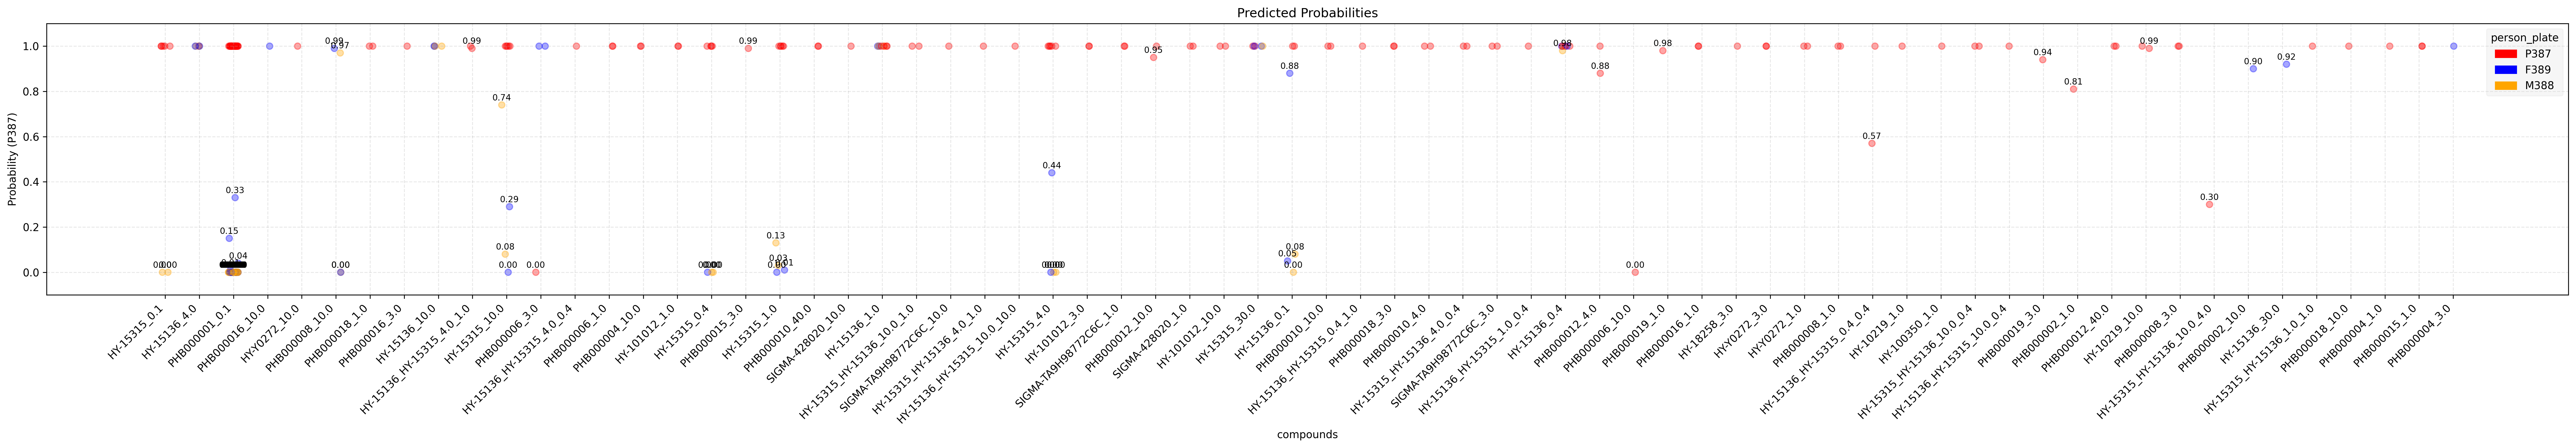

In [59]:
# Ensure required columns exist in `results`
required_cols = {'person_plate', 'proba_P387', 'comp_conc'}
missing = required_cols - set(results.columns)
if missing:
    raise KeyError(f"Missing columns in results: {missing}")

# Add a color column based on person_plate prefix
results['color'] = results['person_plate'].apply(
    lambda x: 'red' if str(x).startswith('P387') else (
        'blue' if str(x).startswith('F389') else 'orange')
)

# Map comp_conc to x positions (categorical → numeric codes)
comp = results['comp_conc'].astype(str)
labels = pd.unique(comp)  # preserve first-seen order
label_to_x = {lab: i for i, lab in enumerate(labels)}
x = comp.map(label_to_x)

# Optional jitter to reduce overlap when many points share the same comp_conc
rng = np.random.default_rng(42)
x_jitter = x + rng.uniform(-0.15, 0.15, size=len(x))

# Dynamic figure width based on number of labels (keeps it readable)
fig_w = max(9, 0.5 * len(labels))
plt.figure(figsize=(fig_w, 6), dpi=300)
plt.scatter(x_jitter, results['proba_P387'], c=results['color'], alpha=0.35)
plt.title('Predicted Probabilities')
plt.xlabel('compounds')
plt.ylabel('Probability (P387)')
plt.ylim(-0.1, 1.1)
plt.grid(True, linestyle='--', alpha=0.3)

# Annotate probabilities below 1.00
for xi, yi in zip(x_jitter, results['proba_P387']):
    if yi < 1.00:
        plt.text(xi, yi + 0.02, f"{yi:.2f}", fontsize=8, ha='center', color='black')

# Set categorical tick labels
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')

# Add legend manually
legend_patches = [
    mpatches.Patch(color='red', label='P387'),
    mpatches.Patch(color='blue', label='F389'),
    mpatches.Patch(color='orange', label='M388')
]
plt.legend(handles=legend_patches, title='person_plate', loc='best', framealpha=0.2, facecolor='lightgray', edgecolor='lightgray')
plt.tight_layout()
plt.show()

### Saving out a high resolution figure

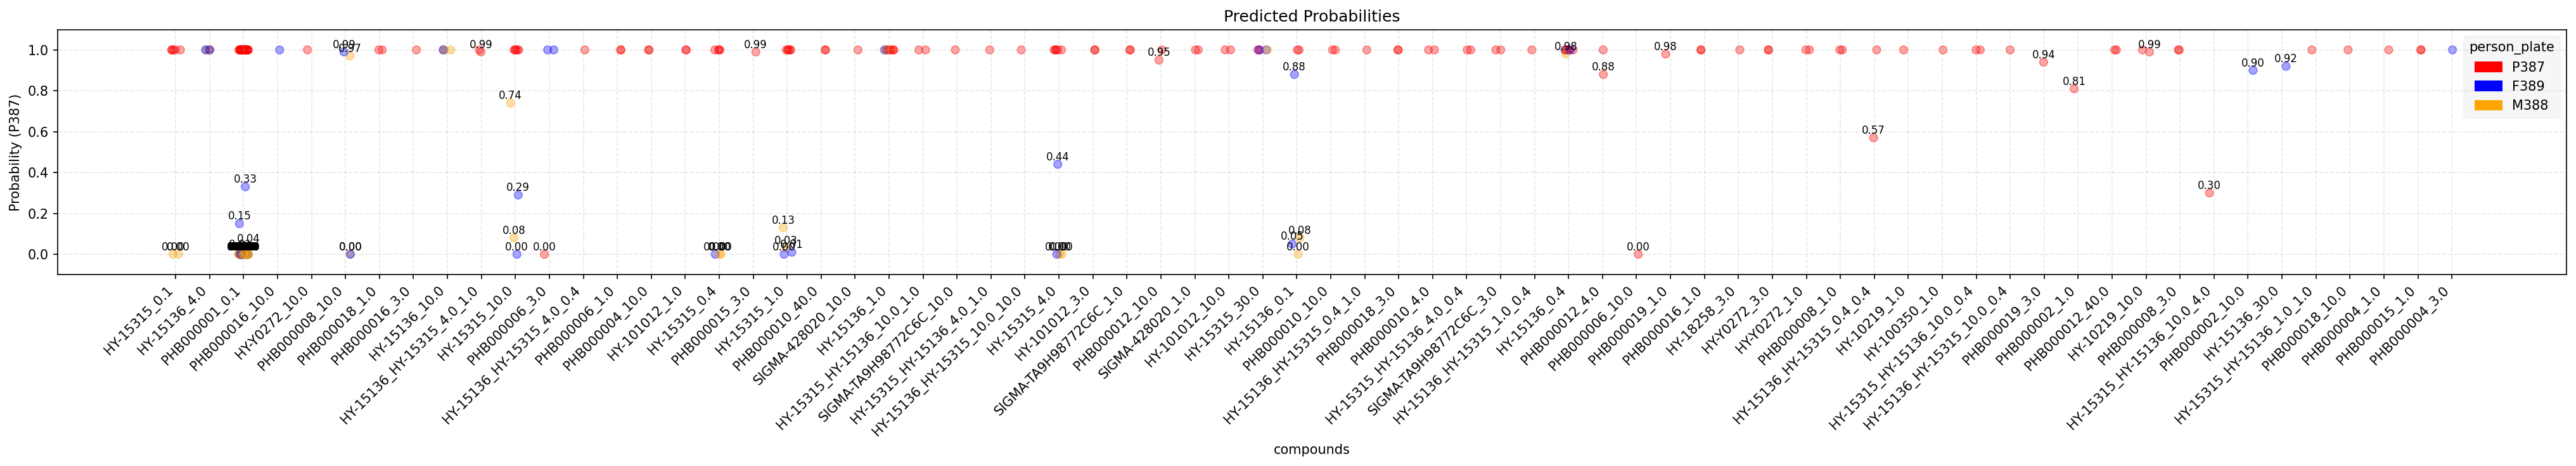

In [58]:
# Ensure required columns exist in `results`
required_cols = {'person_plate', 'proba_P387', 'comp_conc'}
missing = required_cols - set(results.columns)
if missing:
    raise KeyError(f"Missing columns in results: {missing}")

# Add a color column based on person_plate prefix
results['color'] = results['person_plate'].apply(
    lambda x: 'red' if str(x).startswith('P387') else (
        'blue' if str(x).startswith('F389') else 'orange')
)

# Map comp_conc to x positions (categorical → numeric codes)
comp = results['comp_conc'].astype(str)
labels = pd.unique(comp)  # preserve first-seen order
label_to_x = {lab: i for i, lab in enumerate(labels)}
x = comp.map(label_to_x)

# Optional jitter to reduce overlap when many points share the same comp_conc
rng = np.random.default_rng(42)
x_jitter = x + rng.uniform(-0.15, 0.15, size=len(x))

# Dynamic figure width based on number of labels (keeps it readable)
fig_w = max(1, 0.4 * len(labels))
plt.figure(figsize=(fig_w, 5), dpi=150)
plt.scatter(x_jitter, results['proba_P387'], c=results['color'], alpha=0.35)
plt.title('Predicted Probabilities')
plt.xlabel('compounds')
plt.ylabel('Probability (P387)')
plt.ylim(-0.1, 1.1)
plt.grid(True, linestyle='--', alpha=0.3)

# Annotate probabilities below 1.00
for xi, yi in zip(x_jitter, results['proba_P387']):
    if yi < 1.00:
        plt.text(xi, yi + 0.02, f"{yi:.2f}", fontsize=8, ha='center', color='black')

# Set categorical tick labels
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')

# Add legend manually
legend_patches = [
    mpatches.Patch(color='red', label='P387'),
    mpatches.Patch(color='blue', label='F389'),
    mpatches.Patch(color='orange', label='M388')
]
plt.legend(handles=legend_patches, title='person_plate', loc='best', framealpha=0.2, facecolor='lightgray', edgecolor='lightgray')
plt.tight_layout()
plt.savefig("my_figure.png", dpi=300, bbox_inches='tight')
plt.show()

# Fancy Confusion Matrix

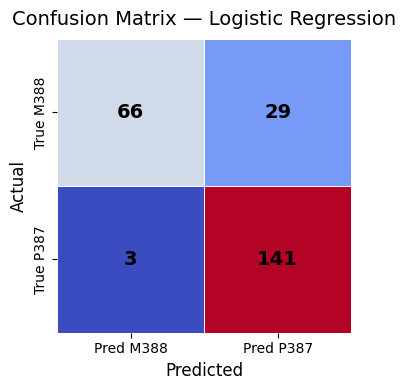

In [60]:
if 'person_plate' in treated_ready.columns:
    y_true = treated_ready['person_plate'].astype(str).str.startswith('P387').astype(int)
    cm = confusion_matrix(y_true, pred, labels=[0,1])
    cm_df = pd.DataFrame(cm, index=['True M388','True P387'], columns=['Pred M388','Pred P387'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='coolwarm', cbar=False, square=True,
                linewidths=.5, annot_kws={"size":14, "weight":"bold", "color":"black"})
    plt.title('Confusion Matrix — Logistic Regression', fontsize=14, pad=10)
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    plt.show()

### Listing classification results

In [69]:
display_df = results[['person_plate', 'comp_conc', 'pred_class', 'proba_P387']]#.sort_values(by='proba_P387', ascending=False).reset_index(drop=True)
# Pretty print
print('\n=== Classification Summary ===')
print(display_df.to_string(index=False))


=== Classification Summary ===
 person_plate                   comp_conc pred_class  proba_P387
M388_PB000188                HY-15315_0.1       M388        0.00
P387_PB000188                HY-15136_4.0       P387        1.00
P387_PB000188               PHB000001_0.1       P387        1.00
F389_PB000188              PHB000016_10.0       P387        1.00
P387_PB000188               HY-Y0272_10.0       P387        1.00
M388_PB000188              PHB000008_10.0       M388        0.00
P387_PB000188               PHB000018_1.0       P387        1.00
P387_PB000188               PHB000016_3.0       P387        1.00
F389_PB000188               HY-15136_10.0       P387        1.00
P387_PB000188   HY-15136_HY-15315_4.0_1.0       P387        0.99
P387_PB000188               HY-15315_10.0       P387        1.00
F389_PB000188               PHB000006_3.0       P387        1.00
P387_PB000188   HY-15136_HY-15315_4.0_0.4       P387        1.00
P387_PB000188               PHB000006_1.0       P387      

### Displaying only specific persons

In [70]:
display_df = display_df[display_df['person_plate'].astype(str).str.startswith(('P387'))].copy()
print(display_df)

      person_plate      comp_conc pred_class  proba_P387
1    P387_PB000188   HY-15136_4.0       P387         1.0
2    P387_PB000188  PHB000001_0.1       P387         1.0
4    P387_PB000188  HY-Y0272_10.0       P387         1.0
6    P387_PB000188  PHB000018_1.0       P387         1.0
7    P387_PB000188  PHB000016_3.0       P387         1.0
..             ...            ...        ...         ...
233  P387_PB000188  HY-101012_1.0       P387         1.0
234  P387_PB000188  PHB000001_0.1       P387         1.0
235  P387_PB000188   HY-Y0272_1.0       P387         1.0
236  P387_PB000188   HY-15315_0.1       P387         1.0
237  P387_PB000188  PHB000015_1.0       P387         1.0

[144 rows x 4 columns]


### Instances with different classification

In [76]:
# Extract first 4 characters of person_plate
prefix = display_df['person_plate'].astype(str).str[:4]

# Condition 1: prefix does NOT match pred_class
cond_mismatch = prefix != display_df['pred_class'].astype(str)

# Condition 2: prefix matches pred_class BUT probability < 0.90
cond_lowprob = (prefix == display_df['pred_class'].astype(str)) & (display_df['proba_P387'] < 0.90)

# Combined subset
df_mismatch = display_df[cond_mismatch | cond_lowprob]
df_mismatch = df_mismatch.sort_values(by='proba_P387')
df_mismatch


,person_plate,comp_conc,pred_class,proba_P387
80,P387_PB000188,PHB000006_10.0,M388,0.00
204,P387_PB000188,PHB000006_3.0,M388,0.00
175,P387_PB000188,HY-15315_HY-15136_10.0_4.0,M388,0.30
118,P387_PB000188,HY-15136_HY-15315_0.4_0.4,P387,0.57
154,P387_PB000188,PHB000002_1.0,P387,0.81
113,P387_PB000188,PHB000012_4.0,P387,0.88
